# Introductory applied machine learning (INFR10069)

# Assignment 4: Feature Engineering

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.


## Mechanics

Fill out this notebook, save it, and **submit it electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 09_Assignment_4.ipynb`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename=09_Assignment_4.ipynb
local_scp_filepath=~/git/iaml2017/${filename}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath} ${UUN}@${server_address}:${filename}
# rsync -rl ${local_scp_filepath} ${UUN}@${server_address}:${filename}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw1 09_Assignment_4.ipynb
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

In this assignment you are asked to import all the packages and modules you will need. Include all required imports and execute the cell below.

In [25]:
from __future__ import print_function, division
%matplotlib inline

In [26]:
import os
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

from scipy.spatial import distance
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from numpy import linalg as LA

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.model_selection import cross_val_score





## Description of the datasets


This assignment is based on two datasets:
1. the 20 Newsgroups Dataset (you should recognise it from Assignment 1)
2. the MNIST digits dataset

### 20 Newsgroups

For convenience, we repeat the description here. This dataset is a collection of approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 different newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related to each other (e.g. comp.sys.ibm.pc.hardware, comp.sys.mac.hardware), while others are highly unrelated (e.g misc.forsale, soc.religion.christian). 

To save you time and to make the problem manageable with limited computational resources, we preprocessed the original dataset. We will use documents from only 5 out of the 20 newsgroups, which results in a 5-class problem. More specifically the 5 classes correspond to the following newsgroups: 
1. `alt.atheism`
2. `comp.sys.ibm.pc.hardware`
3. `comp.sys.mac.hardware`
4. `rec.sport.baseball`
5. `rec.sport.hockey `

However, note here that classes 2-3 and 4-5 are rather closely related.

**In contrast to Assignment 1**, we have opted to use tf-idf weights ([term frequency - inverse document frequency](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))
for each word instead of the frequency counts. These weights represent the importance of a word to a
document with respect to a collection of documents. The importance increases proportionally to the number
of times a word appears in the document and decreases proportionally to the number of times the word
appears in the whole corpus. 

Additionally we preprocess the data to include the most frequent 1000 words that are in greater than 2 documents, less than half of all documents, and that are not [stop words](https://en.wikipedia.org/wiki/Stop_words).

We will perform all this preprocessing for you.


### MNIST
This MNIST Dataset is a collection handwritten digits. The samples are partitioned (nearly) evenly across the 10 different digit classes {0, 1, . . . , 9}. We use a preprocessed version for which the data are $8 \times 8$ pixel images containing one digit each. For further details on how the digits are preprocessed, see the sklearn documentation. The images are grayscale, with each pixel taking values in {0, 1, . . . , 16}, where 0 corresponds to black (weakest intensity) and 16 corresponds to white (strongest intensity). Therefore, the dataset is a N × 64
dimensional matrix where each dimension corresponds to a pixel from the image and N is the number of
images. 

Again, to save you time, we perfom the import for you.

## 1. Clustering the 20 Newsgroups Data [50%]

In part 1 we will cluster the observations in the 20 Newsgroups dataset using the k-means algorithm. Each row of the dataset represents a document with bag of words features. If we were not given the labels for each document (i.e. the newsgroup it came from), clustering could allow us to infer which documents should have the same label. Observing common words within each cluster may allow us to give meaning to these inferred labels too.

First we'll import the data and fit and evaluate k-means with 5 cluster centres. Next, we will try and infer which cluster corresponds with which label. Finally, we will pretend we don't know the number of clusters there should be, as is the normal scenario with large unlabeled data, and investigate the effect of using a different number of cluster centres (i.e. varying `k`).

### ========== Question 1.0 --- [0 marks] ==========

Run the below cells to import the data. It would be a good idea to understand the code but it's not strictly necessary (see the [sklearn documentation](http://scikit-learn.org/0.17/datasets/index.html#the-20-newsgroups-text-dataset)).

*This may take a wee while as it will download the dataset*

**Do not change any of the code in this question**

In [27]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
cats = ['alt.atheism', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 
        'rec.sport.baseball', 'rec.sport.hockey']
newsgroups_train = fetch_20newsgroups(subset='train', categories=cats, 
                                      remove=('headers', 'footers', 'quotes'))
vectorizer = TfidfVectorizer(max_df=0.5, max_features=1000,
                             min_df=2, stop_words='english', 
                             token_pattern='(?u)\\b[A-z]{2,}\\b')
X_sparse = vectorizer.fit_transform(newsgroups_train.data)
y_num = newsgroups_train.target
X = pd.DataFrame(X_sparse.todense(), columns=vectorizer.get_feature_names())
y = np.array(cats)[y_num]

### ========== Question 1.1 --- [5 marks] ==========

Perform an initial inspection of the data, X and y (no more than 5 lines of code). Below the code, describe what the data are i.e. what the objects are, and what they represent (fewer than 4 sentences).

In [28]:
print('Number of instances: {}, number of attributes: {}'.format(X.shape[0], X.shape[1]))

print('Objects: {}'.format(y))

cats

Number of instances: 2845, number of attributes: 1000
Objects: ['rec.sport.baseball' 'rec.sport.baseball' 'rec.sport.hockey' ...,
 'comp.sys.ibm.pc.hardware' 'rec.sport.hockey' 'rec.sport.hockey']


['alt.atheism',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.sport.baseball',
 'rec.sport.hockey']

y represents the objects. It is all the classes that corresponds to each of the 1000 attributes.

cats represnt the classes or the five different newsgroups, each corresponding to a different topic. 

### ========== Question 1.2 --- [2 marks] ==========

Initialise a [k-means clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) object with 5 clusters. Make sure that you can reproduce your results exactly. *Hint: there is an argument for this*. You need only set two arguments; others can be kept as default. Call the instantiated object `kmeans`. Use the `fit()` method to fit to the training data (X imported above)

In [29]:
# Setting random_state so that I can reproduce my results
kmeans = KMeans(n_clusters=5, random_state=0)  
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

### ========== Question 1.3 --- [6 marks] ==========

Evauate the quality of this fit.

1. Get a feel for the average distance of a data point from the centre: print the mean of the euclidean distances of all data points from the mean data point (in the whole dataset)
1. print the inertia of the model. *Hint: check the properties of the kmeans object*
1. print the adjusted rand index of the model. *Hint: `adjusted_rand_score`*

Below the code: 
1. Define what the inertia and adjusted rand score are (one or two sentences). *Hint: check [sklearn documentation](http://scikit-learn.org/stable/modules/clustering.html)*
1. Comment on the quality of the clustering implied by the adjusted rand score and inertia

In [30]:
mean_datap = pd.DataFrame.mean(X).values
#print(mean_datap)
m_datap_ls = []
for index, row in X.iterrows():
    dist = distance.euclidean(mean_datap, row)
    m_datap_ls.append(dist)
#print(m_datap_ls)

print('Mean of the euclidean distances of all data points from the mean data point: {}'.format(np.mean(m_datap_ls)))
print('Inertia and adjusted rand index of the model:')
print(kmeans.inertia_, adjusted_rand_score(y, kmeans.labels_))

Mean of the euclidean distances of all data points from the mean data point: 0.954584949852
Inertia and adjusted rand index of the model:
2593.26745106 0.236459358529


1. According to the documentation, "inertia, or the within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are", basically a measure of spread between the datapoint and the closest cluster - and the lower the value, the better. Adjusted rand score "is a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization"; basically the similarity between two data clusters where the higher the score, the more similar they are.

2. The value of inertia here is not at all good, showing no coherence at all. The adjusted rand score is quite low, showing us that there is very litte similarity between the objects and the cluster labels.

### ========== Question 1.4 --- [3 marks] ==========

Print:
1. the number of datapoints with each label
2. the number of datapoints assigned to each cluster. *Hint: you should use the properties of the kmeans object you just fit.* 

Below the code, comment on the distribution of datapoints to cluster centres.

In [31]:
# Number of datapoints for each label
c_label = Counter(y)
print(c_label)


Counter({'rec.sport.hockey': 600, 'rec.sport.baseball': 597, 'comp.sys.ibm.pc.hardware': 590, 'comp.sys.mac.hardware': 578, 'alt.atheism': 480})


In [32]:
# Number of datapoints assigned to each cluster
c_label = Counter(kmeans.labels_)
print(c_label)


Counter({0: 1028, 4: 688, 3: 601, 2: 307, 1: 221})


The distribution of datapoints to cluster centres are quite unbalanced. We assume that clusters share certain characteristics at least within a boundary. Because we measure the distances between clusters, if one distribution is much more prominent than another, the less prominent one could be shadowed. This means the less prominent cluster may not be found at all if they get pushed too far away from the prominent cluster. 

### ========== Question 1.5 --- [3 marks] ==========

We can't visualise these cluster centres directly, since they are 1000 dimensional. However, we can at least measure the distance between each centre. Create a distance matrix such that the entry with index (i,j) shows the distance between centre i and j. *Hint: again you should use the properties of the kmeans object you just fit.*

In [33]:
#print(kmeans.labels_)

d_matrix = []

for i in kmeans.cluster_centers_:
    for j in kmeans.cluster_centers_:
        dist_ij = distance.euclidean(i, j)
        d_matrix.append(dist_ij)
print(d_matrix)

# entry with index (i,j) ??

[0.0, 0.34374520806212416, 0.2333048542969131, 0.20265703207211694, 0.18763549005402125, 0.34374520806212416, 0.0, 0.41216403530254325, 0.407678804912282, 0.32073454332936085, 0.2333048542969131, 0.41216403530254325, 0.0, 0.2994364727050916, 0.2927135681468528, 0.20265703207211694, 0.407678804912282, 0.2994364727050916, 0.0, 0.2884249147193866, 0.18763549005402125, 0.32073454332936085, 0.2927135681468528, 0.2884249147193866, 0.0]


### ========== Question 1.6 --- [3 marks] ==========

For each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Below the code, comment on the quality of the fit. *Hint: you can do the main plot (without labels) in one line with seaborn (you're free to do it as you like though!).*

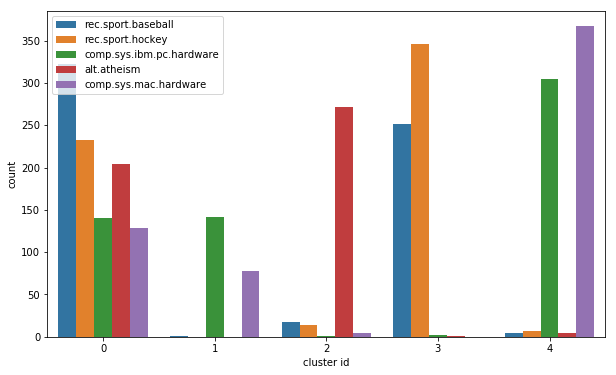

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

From the distribution, it seems that the clusters are not similar to the original classes, instead showing us a less equal distribution. If we were looking for something new, a new relationship between attributes, then the fit is alright. However, if we compare it to our actual classes, it's not very good at all.

### ========== Question 1.7 --- [8 marks] ==========

We will now investigate using dimensionality reduction to try and improve the quality of the fit. Use the sklearn implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to create a reduced reduced dataset for `n_components` = [1,2,3,5,10,20,50,100,500,1000] i.e. create datasets that are of shape `(N, d)` for `d` in `n_components`. Fit k-means to each reduced dataset and report the `inertia` and `adjusted_rand_score` for each iteration.

Plot `adjusted_rand_score` against number of principal components (label graph). Use a log scale on the x axis. Below the graph:
1. describe what it shows
1. explain why we cannot use inertia to choose the best number of principal components
1. explain why dimensionality reduction could help k-means perform better

In [35]:
n_componentS = [1,2,3,5,10,20,50,100,500,1000]
matrix = []

for n in n_componentS:
    pca = PCA(n_components= n)
    pca_X = pca.fit_transform(X)
    kmeans_pca = KMeans(n_clusters=5, random_state=0)  
    kmeans_pca.fit(pca_X)
    print(kmeans_pca.inertia_, adjusted_rand_score(y, kmeans_pca.labels_))
    matrix.append(adjusted_rand_score(y, kmeans_pca.labels_))

    

2.82039843582 0.210112876666
10.5690054469 0.271416306816
20.4461055007 0.242169305637
49.9271707776 0.226721817007
117.688951619 0.212856362979
230.524892446 0.211257465616
488.731562223 0.198149442857
800.272183383 0.222201641865
2131.50473066 0.218833895237
2593.48292543 0.228324137516


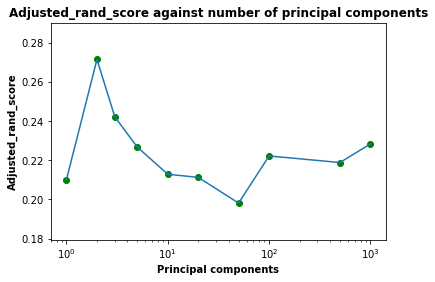

In [36]:
# Plotting a label graph

plt.scatter(n_componentS, matrix, color="g", marker="o")

plt.semilogx(n_componentS, matrix)

# Title and labels
plt.title('Adjusted_rand_score against number of principal components', fontweight='bold')
plt.ylabel('Adjusted_rand_score', fontweight='bold')
plt.xlabel('Principal components', fontweight='bold')

plt.show()

1. The plot shows various adjusted rand scores ranging from approximately 0.20 to 0.27 when plotted against it's associated principle components. The score of 0.27 is the least random, being furthest away from 0 (though it's still an overall bad score).


2. Unlike adjusted rand scores, the inertia is dependent on it's principal component's dimensions/features. Using inertia to choose the best number of principal components is unrealiable as it's dimension vary with no order. 


3. Dimensionality reduction is a form of feature engineering. Specifically, feature extraction in the case of k-means where useless columns are removed as part of preprocessing. This inadvertantly helps k-means perform better.

### ========== Question 1.8 --- [6 marks] ==========

1. So we can visualise the data, create X_2d: the dataset X transformed down to 2 principal component dimensions. Use sklearn's implementation of [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and its method `fit_transform()` to do this (as above). 

1. Create a new k-means object, `kmeans_pca`, and fit the 2d data to it. Show the adjusted rand score.

1. As above, for each cluster centre label, plot the counts of the true labels. The cluster labels are a property of the k-means object, the true labels are contained in `y`. Make sure that you label the plot axes and legend clearly. Print below it the number of data points each cluster is responsible for.

1. Finally, below the plot, comment on the difference between these clusters and the clusters on the 1000 dimensional data with respect to the distribution of the labels in each. Are they better?

In [37]:
# 1. Dataset X transformed down to 2 principal component dimensions
pca2 = PCA(n_components= 2)
X_2d = pca2.fit_transform(X)

# 2. New k-means object and adjusted rand score
kmeans_pca2 = KMeans(n_clusters=5, random_state=0)  
kmeans_X_2d = kmeans_pca2.fit(X_2d)
print('Mean of the euclidean distances of all data points from the mean data point: {}'.format(adjusted_rand_score(y, kmeans_X_2d.labels_)))

Mean of the euclidean distances of all data points from the mean data point: 0.268356045768


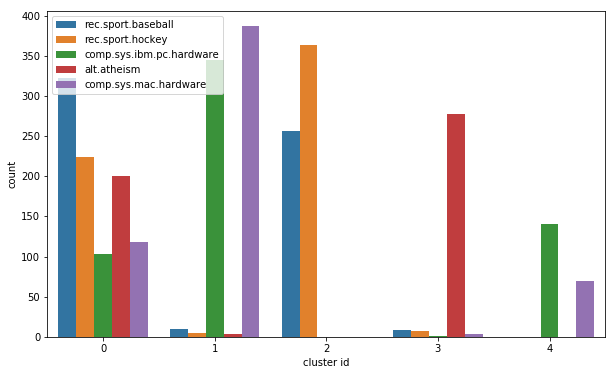

Counter({0: 967, 1: 750, 2: 620, 3: 298, 4: 210})


In [38]:
# 3. Plotting
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=kmeans_X_2d.labels_, hue=y, ax=ax)
plt.xlabel('cluster id')
plt.show()

# Number of datapoints assigned to each cluster
c_label = Counter(kmeans_X_2d.labels_)
print(c_label)


The quality of the fit is only slightly better. Before, the number of datapoints assigned to each cluster was more unbalanced, though not by much. Hence, there is a small difference between the plots.

### ========== Question 1.9 --- [1 mark] ==========

Given the above plot, apply a label to each cluster centre. Create a new vector, `labels_interp`, which is the same as `kmeans.labels_`, but instead of numbers, the interpreted label of the cluster centre. For example, if you decided cluster 0 was 'apples', 1 was 'pears', 2 was 'stairs', and `kmeans.labels_` was `[2, 0, 1, 1, 0]`, create  `labels_interp = ['stairs', 'apples', 'pears', 'pears', 'apples']`. Hint: an example of how to do this is given in the last line of Question 1.0.

**N.B. be careful to use the `kmeans_pca` object you created above, not the first kmeans object you made**

In [39]:
labels_interp = ['rec.sport.baseball', 'comp.sys.mac.hardware', 'rec.sport.hockey', 'alt.atheism', 'comp.sys.ibm.pc.hardware']

y2 = np.array(labels_interp)[kmeans_X_2d.labels_]

### ========== Question 1.10 --- [3 marks] ==========

Produce a normalised (by true label) confusion matrix of your interpreted labels from the k-means clustering and the true labels. As usual, you may use any functions from previous assignments or labs. Clearly label the axes of the plot. Check that these confusions correlate with your expectations! N.B. this is just a slightly different way of interpreting the information in the count plot above (focussed this time on the true labels).

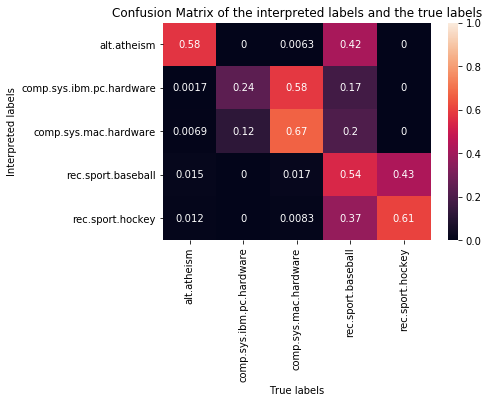

In [40]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm, xticklabels=cats, yticklabels=cats, vmin=0., vmax=1., annot=True)
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.xlabel('True labels')
    plt.ylabel('Interpreted labels')
    
cm = confusion_matrix(y, y2)
cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_norm, classes=cats, title='Confusion Matrix of the interpreted labels and the true labels')

### ========== Question 1.11 --- [6 marks] ==========

Since we are now in 2 dimensions, let's visualise the data, the cluster centres, and the decision boundaries via a [Voronoi_diagram](https://en.wikipedia.org/wiki/Voronoi_diagram). You'll essentially be able to copy and paste the code from the [sklearn kmeans digits example](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) and edit a few bits to get over half marks.

Clearly mark each cluster centre.

For full marks, additionally:
* label each cluster centre with the inferred cluster label
* create a second plot which clearly shows where the true classes lie within the pca space e.g. the [sklearn PCA example here](http://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_vs_lda.html)

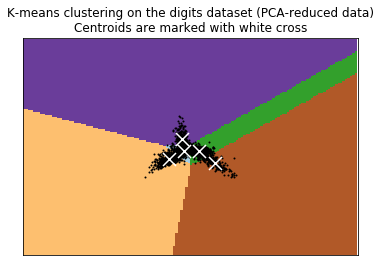

In [41]:
reduced_data = X_2d
kmeans1 = kmeans_X_2d

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans1.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans1.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

### ========== Question 1.12 --- [4 marks] ==========

*Write a **1 or 2 sentence** answer for each question*.

1. Is the kmeans algorithm deterministic?
1. Did the algorithm you ran above in Question 1.2 (fitting k-means) do multiple initialisations? If not, explain why it was not necessary. If so, how was the final model selected?
1. The default method for initialising centres in the sklearn implementation is [kmeans++](https://en.wikipedia.org/wiki/K-means%2B%2B). Name another method for initialising and a problem with it.

1. Besides the initialization, the kmeans algorithm is deterministic. It chooses the first cluster randomly but it's resulting behaviour is pre-determined by it's initial state and inputs which is not random.

2. No, the algorithm was fit once. But to avoid getting stuck on a bad local minimum, kmeans++ was used and through this, 10 initializations were done on each of the initialized kmeans. This allows for a smart initialization as it has better cluster heterogeneity.

3. Another method is the MacQueen method for initialising. This method is sensitive to the order in which points are relocated. Depending on the order, different solutions are yield (Morissette & Chartier, 2013).


## 2. PCA with MNIST Data [50%]

In the second part of the assignment we will explore the MNIST digits dataset. We expect the digits to lie in a lower-dimensional manifold and want to examine the representation we get by applying Principal Components Analysis (PCA). PCA maps the data into a new space by effectively rotating the base vectors of the input space to the directions with the highest variance. We will assess the impact of this mapping to the classification task and the separability of the data in the PCA space.

### ========== Question 2.0 --- [0 marks] ==========

Run the cell below to load the digits object and print its description.

**Do not change any of the code in this question**

In [42]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits.DESCR)

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

### ========== Question 2.1 --- [8 marks] ==========

If you execute `digits.keys()`, you'll see this object contains the data, the targets (the labels), and the images (the data reshaped to 8x8 images). More typically the mnist data are [28x28 images](http://yann.lecun.com/exdb/mnist/), but this is a preprocessed version. 

1. Use the pandas describe method on the data to get a feel for the range of each dimension
1. What are the max/min values for each dimension?
1. Extract the standard deviations from the output of the describe method (just another DataFrame with 'std' as one of the index values), reshape to an 8x8 image, and plot a heatmap (use `sns.heatmap()`) to show you which dimensions vary the most. For a bonus mark, produce a plot like this for each digit. *Hint: you can use `.groupby(digits.target)` before calling `.describe()`*.
1. Use `sns.heatmap()` to plot the first 9 digits in the dataset

Below the plots, answer this question in a markdown cell:
1. Are all of the dimensions going to be equally helpful for modelling? Explain.

In [43]:
print(digits.keys())

digits_data = pd.DataFrame(digits.data)

#1. range of each dimension
print(digits_data.describe())

# 2. Max and min values for each dimension
digits_data.describe().loc[['max', 'min']]

['images', 'data', 'target_names', 'DESCR', 'target']
           0            1            2            3            4   \
count  1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean      0.0     0.303840     5.204786    11.835838    11.848080   
std       0.0     0.907192     4.754826     4.248842     4.287388   
min       0.0     0.000000     0.000000     0.000000     0.000000   
25%       0.0     0.000000     1.000000    10.000000    10.000000   
50%       0.0     0.000000     4.000000    13.000000    13.000000   
75%       0.0     0.000000     9.000000    15.000000    15.000000   
max       0.0     8.000000    16.000000    16.000000    16.000000   

                5            6            7            8            9   \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000   
mean      5.781859     1.362270     0.129661     0.005565     1.993879   
std       5.666418     3.325775     1.037383     0.094222     3.196160   
min       0.000000     0.000

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
max,0.0,8.0,16.0,16.0,16.0,16.0,16.0,15.0,2.0,16.0,...,16.0,13.0,1.0,9.0,16.0,16.0,16.0,16.0,16.0,16.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# 3. Extracting std and reshaping 
digits_data_std = pd.DataFrame(digits_data.describe().loc[['std']].values.reshape(8, 8))
digits_data_std

,0,1,2,3,4,5,6,7
0,0.000000,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383
1,0.094222,3.196160,5.421456,3.977543,4.782681,6.052960,3.586321,0.827915
2,0.062368,3.576301,5.690767,5.802662,6.175729,6.197322,3.259870,0.438597
3,0.033352,3.146532,6.192038,5.882936,6.152093,5.872556,3.686456,0.047140
4,0.000000,3.480372,6.324687,6.268391,5.933490,5.870648,3.537283,0.000000
5,0.145185,2.981816,6.537955,6.441378,6.259511,5.695527,4.330951,0.307356
6,0.204223,1.746153,5.644496,5.226948,5.302048,6.031154,4.919406,0.984401
7,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122


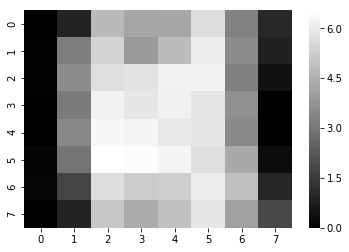

In [45]:
# Plotting heat map of reshaped std data
std_hot = sns.heatmap(digits_data_std, cmap=plt.cm.gray)

Heatmap: 0


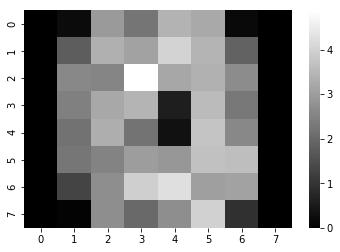

Heatmap: 1


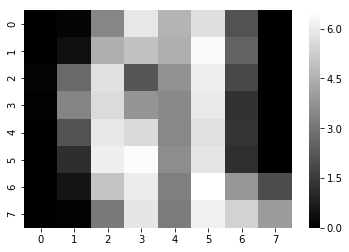

Heatmap: 2


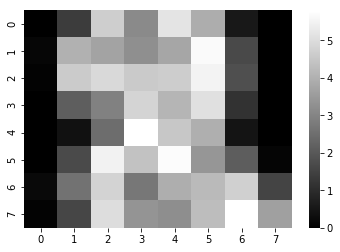

Heatmap: 3


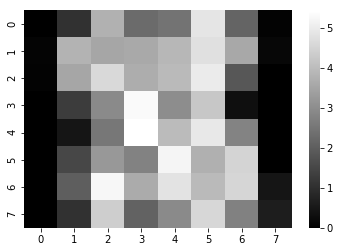

Heatmap: 4


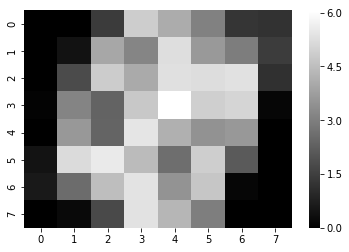

Heatmap: 5


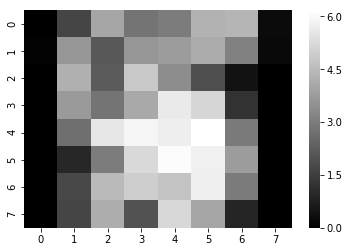

Heatmap: 6


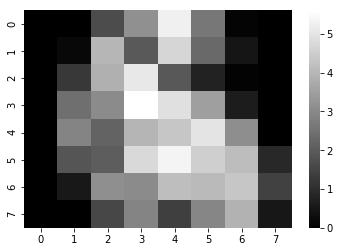

Heatmap: 7


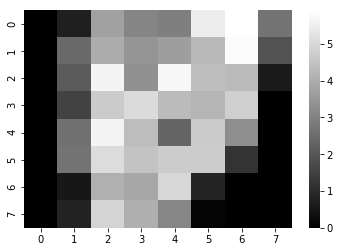

Heatmap: 8


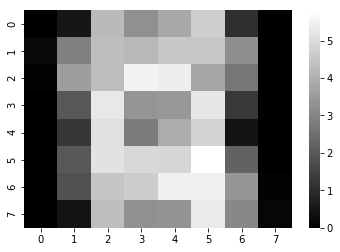

Heatmap: 9


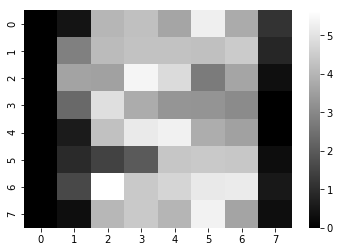

In [46]:
#Extra_point
target_digits = digits_data.groupby(digits.target).std().values
target_digits = target_digits.reshape(10, 8, 8)

for i in range(10):
    sns.heatmap(data = target_digits[i], cmap=plt.cm.gray)
    print('Heatmap: {}'.format(i))
    plt.show()
    

Heatmap: [[  0.   0.   5.  13.   9.   1.   0.   0.]
 [  0.   0.  13.  15.  10.  15.   5.   0.]
 [  0.   3.  15.   2.   0.  11.   8.   0.]
 [  0.   4.  12.   0.   0.   8.   8.   0.]
 [  0.   5.   8.   0.   0.   9.   8.   0.]
 [  0.   4.  11.   0.   1.  12.   7.   0.]
 [  0.   2.  14.   5.  10.  12.   0.   0.]
 [  0.   0.   6.  13.  10.   0.   0.   0.]]


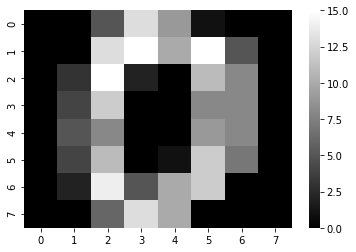

Heatmap: [[  0.   0.   0.  12.  13.   5.   0.   0.]
 [  0.   0.   0.  11.  16.   9.   0.   0.]
 [  0.   0.   3.  15.  16.   6.   0.   0.]
 [  0.   7.  15.  16.  16.   2.   0.   0.]
 [  0.   0.   1.  16.  16.   3.   0.   0.]
 [  0.   0.   1.  16.  16.   6.   0.   0.]
 [  0.   0.   1.  16.  16.   6.   0.   0.]
 [  0.   0.   0.  11.  16.  10.   0.   0.]]


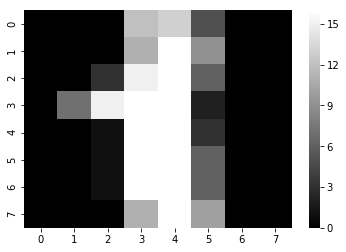

Heatmap: [[  0.   0.   0.   4.  15.  12.   0.   0.]
 [  0.   0.   3.  16.  15.  14.   0.   0.]
 [  0.   0.   8.  13.   8.  16.   0.   0.]
 [  0.   0.   1.   6.  15.  11.   0.   0.]
 [  0.   1.   8.  13.  15.   1.   0.   0.]
 [  0.   9.  16.  16.   5.   0.   0.   0.]
 [  0.   3.  13.  16.  16.  11.   5.   0.]
 [  0.   0.   0.   3.  11.  16.   9.   0.]]


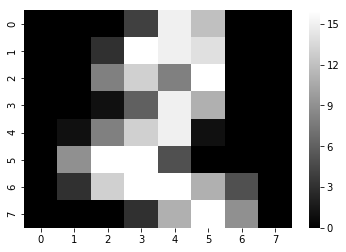

Heatmap: [[  0.   0.   7.  15.  13.   1.   0.   0.]
 [  0.   8.  13.   6.  15.   4.   0.   0.]
 [  0.   2.   1.  13.  13.   0.   0.   0.]
 [  0.   0.   2.  15.  11.   1.   0.   0.]
 [  0.   0.   0.   1.  12.  12.   1.   0.]
 [  0.   0.   0.   0.   1.  10.   8.   0.]
 [  0.   0.   8.   4.   5.  14.   9.   0.]
 [  0.   0.   7.  13.  13.   9.   0.   0.]]


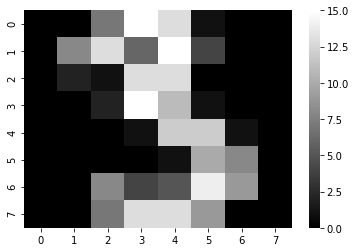

Heatmap: [[  0.   0.   0.   1.  11.   0.   0.   0.]
 [  0.   0.   0.   7.   8.   0.   0.   0.]
 [  0.   0.   1.  13.   6.   2.   2.   0.]
 [  0.   0.   7.  15.   0.   9.   8.   0.]
 [  0.   5.  16.  10.   0.  16.   6.   0.]
 [  0.   4.  15.  16.  13.  16.   1.   0.]
 [  0.   0.   0.   3.  15.  10.   0.   0.]
 [  0.   0.   0.   2.  16.   4.   0.   0.]]


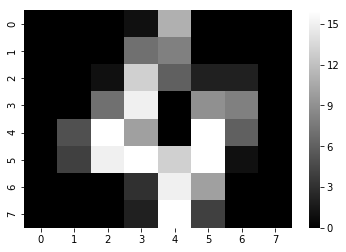

Heatmap: [[  0.   0.  12.  10.   0.   0.   0.   0.]
 [  0.   0.  14.  16.  16.  14.   0.   0.]
 [  0.   0.  13.  16.  15.  10.   1.   0.]
 [  0.   0.  11.  16.  16.   7.   0.   0.]
 [  0.   0.   0.   4.   7.  16.   7.   0.]
 [  0.   0.   0.   0.   4.  16.   9.   0.]
 [  0.   0.   5.   4.  12.  16.   4.   0.]
 [  0.   0.   9.  16.  16.  10.   0.   0.]]


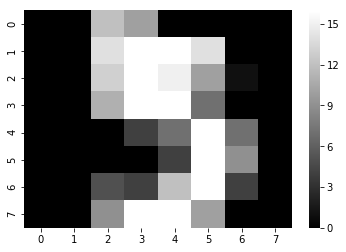

Heatmap: [[  0.   0.   0.  12.  13.   0.   0.   0.]
 [  0.   0.   5.  16.   8.   0.   0.   0.]
 [  0.   0.  13.  16.   3.   0.   0.   0.]
 [  0.   0.  14.  13.   0.   0.   0.   0.]
 [  0.   0.  15.  12.   7.   2.   0.   0.]
 [  0.   0.  13.  16.  13.  16.   3.   0.]
 [  0.   0.   7.  16.  11.  15.   8.   0.]
 [  0.   0.   1.   9.  15.  11.   3.   0.]]


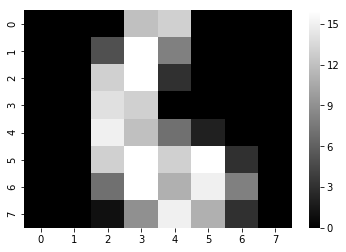

Heatmap: [[  0.   0.   7.   8.  13.  16.  15.   1.]
 [  0.   0.   7.   7.   4.  11.  12.   0.]
 [  0.   0.   0.   0.   8.  13.   1.   0.]
 [  0.   4.   8.   8.  15.  15.   6.   0.]
 [  0.   2.  11.  15.  15.   4.   0.   0.]
 [  0.   0.   0.  16.   5.   0.   0.   0.]
 [  0.   0.   9.  15.   1.   0.   0.   0.]
 [  0.   0.  13.   5.   0.   0.   0.   0.]]


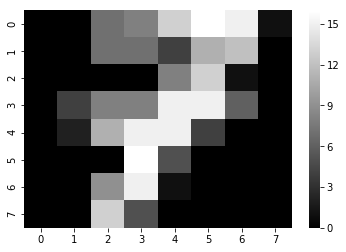

Heatmap: [[  0.   0.   9.  14.   8.   1.   0.   0.]
 [  0.   0.  12.  14.  14.  12.   0.   0.]
 [  0.   0.   9.  10.   0.  15.   4.   0.]
 [  0.   0.   3.  16.  12.  14.   2.   0.]
 [  0.   0.   4.  16.  16.   2.   0.   0.]
 [  0.   3.  16.   8.  10.  13.   2.   0.]
 [  0.   1.  15.   1.   3.  16.   8.   0.]
 [  0.   0.  11.  16.  15.  11.   1.   0.]]


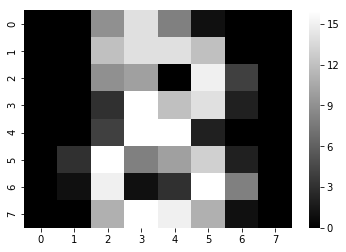

In [47]:

digits.data = digits.data[:9].reshape(9, 8, 8)

for d in digits.data:
    sns.heatmap(data = d, cmap=plt.cm.gray)
    print('Heatmap: {}'.format(d))
    plt.show()  
    


No, not all of the dimensions are going to be equally helpful for modelling. Not all attributes are useful and we only need the attributes which show us a high variance when feature engineering.

### ========== Question 2.2 --- [10 marks] ==========

Create a new `PCA` object with `n_components = digits.data.shape[1]`. Plot the explained variance **ratio** against the number of components. You may find [this example](http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html#sphx-glr-auto-examples-plot-digits-pipe-py) quite handy...

Find the point where 95% of the variance has been explained. Use `plt.vlines()` to add a dotted verical line to the graph at that point and use `plt.annotate()` to label the number of eigenvectors used to explain that variance.

Below the plot, explain what you observe. What does this suggest about the data?

In [48]:
X = pd.DataFrame(digits['data'])
#X.shape
#
## Creating new PCA object
pca_pipe = PCA(n_components= digits.data.shape[1])
pca_digits_pipe = pca_pipe.fit(X)


ValueError: Must pass 2-d input

In [ ]:
# Creating new PCA object
#pca_pipe = PCA(n_components= digits.data.shape[1])
#pca_digits_pipe = pca_pipe.fit_transform(digits.data)

#Plotting
plt.plot((np.expand_dims(np.arange(digits.data.shape[1]), 1)), pca_pipe.explained_variance_ratio_)

# Title and labels
plt.title('Explained variance ratio against the number of components', fontweight='bold')
plt.ylabel('Explained variance ratio', fontweight='bold')
plt.xlabel('Number of components', fontweight='bold')

# 95% of the variance
np.where(pca_pipe.explained_variance_ratio_.cumsum()>.95)[0][0] 
# gets the index value 28 BUT because we can't have 0 attributes, we add 1, making the x value for vlines = 29

plt.vlines(x=29, ymin=0.00, ymax = 0.14, linewidth=2, color='r')
plt.annotate('Eigenvectors 29', xy=(29, 0.04), arrowprops=dict(arrowstyle="->"))
plt.show()

The plot shows that at 29 principle components, 95% of the data is explained. 

### ========== Question 2.3 --- [8 marks] ==========

You will find the eigenvectors stored within `pca.components_`. Reuse your code from Question 2.1 and plot the first 9 principal components (PCs). Below, plot `pca.mean_`. 

In [ ]:
#digits.data = digits.data[:8]

pca_ = (pca_pipe.components_[0:9])

p_c_a = pca_.reshape(9, 8, 8)


for p in p_c_a:
    sns.heatmap(data = p, cmap=plt.cm.rainbow)
    #print('Heatmap: {}'.format())
    plt.show()
    
pca.mean_

### ========== Question 2.4 --- [10 marks] ==========

Now we want to make clear how these eigenvectors and the mean are used to approximate the data. `pca.transform(digits.data[idx,:].reshape(1, -1)).flatten()` will transform the digit in row `idx` into pca space. Another way to think about this is that it will give you the coefficents to multiply each eigenvector by and to add to the mean digit such that you can reconstruct the digit.

For the digit with idx = 0 (which should itself be a zero), create 4 plots:
1. The original digit
1. The digit reconstructed using 1 principal component
1. The digit reconstructed using 2 principal components
1. The digit reconstructed using 5 principal components

In the plot titles show:
1. the number of principal components used
1. the percentage of variance explained by that number of principal components
1. the coefficients of each principal component rounded to nearest integer (tip, convert to integers to reduce print space), i.e. the PCA space vector.

Below the plots, comment on the result. Do the eigenvectors produce realistic data?

*Your answer goes here*

### ========== Question 2.5 --- [14 marks] ==========

**Challenge question** 

Fit 4 models:
1. SVC with a linear kernel, no shrinking, and a random_state on digit data
1. SVC with a linear kernel, no shrinking, and the same random_state on pca transformed digit data (use the full 64 component pca above)
1. Gaussian Naive Bayes Classifier on digit data
1. Gaussian Naive Bayes Classifier on pca transformed digit data (use the full 64 component pca above)

Use 5 fold cross validation and take the mean fold score as the result. Plot or print the results.

Below the code, explain why one classifier improved when we used PCA, but the other did not!

In [ ]:
# 1. Linear SVM
svc_linear = SVC(kernel = 'linear', shrinking= False, random_state = 0)
print('Mean fold score for Linear SVM: {}'.format(np.mean(cross_val_score(svc_linear, digits.data, digits.target, cv = kf))))

In [ ]:
# 2. Linear SVM on pca transformed digit data
pca_s = PCA(n_components= 64)
pca_svm = pca_s.fit_transform(digits.data)

svc_linear_transf = SVC(kernel = 'linear', shrinking= False, random_state = 0)

print('Mean fold score for Linear SVM on PCA transformed data: {}'.format(np.mean(cross_val_score(svc_linear_transf, pca_svm, digits.target, cv = kf))))

In [ ]:
# 3 Gaussian Naive Bayes
nb_gau = GaussianNB()

print('Mean fold score for Gaussian Naive Bayes: {}'.format(np.mean(cross_val_score(nb_gau, digits.data, digits.target, cv = kf))))

In [ ]:
# 4. Gaussian Naive Bayes on pca transformed digit data
pca_nb = PCA(n_components= 64)
pca_gnb = pca_nb.fit_transform(digits.data)

nb_gau = GaussianNB()

print('Mean fold score for Gaussian Naive Bayes on PCA transformed data: {}'.format(np.mean(cross_val_score(nb_gau, pca_gnb, digits.target, cv = kf))))

In [ ]:
a = ['1', '2', '3', '4']
z = ['Linear SVM', 'Linear SVM with PCA', 'Gaussian NB', 'Gaussian NB with PCA']
b = ['0.984422779325', '0.984422779325', '0.833611884865', '0.88872175797' ]

# Plotting a graph
plt.scatter(a, b, color="m", marker="*")
plt.xlabel(z)

# Title and labels
plt.title('Classifiers against Mean fold scores', fontweight='bold')
plt.ylabel('Mean fold scores', fontweight='bold')
plt.xlabel('Classifiers', fontweight='bold')


plt.show()

PCA aims to un-correlate the variables in a dataset. Looking at the two classifiers, support vectors in Linear SVMs are not dependent on one another (different weight vectors have similar outputs). Where as, Naive Bayes works on the indepence assumption, assuming a correlation between variables. With PCA doing what it does, it further adds independence to NB while not really affecting a Linear SVM. In this way, NB has an even greater spread or variance thus allowing for a better generalisation. This orthogonal relationship is why Naive Bayes improves when we use PCA.  